# AUTO-PLATE-RECOGNITION
#### UCLA CS145 - Professor Si Si
#### TEAM NAME: Deep Learners
----
#### TEAM MEMBERS:
Caleb Lee   UID: 305-330-193    Email: bkcaleb45@g.ucla.edu 

Dylan Phe	UID: 505-834-475	Email: dylanphe@g.ucla.edu

Kevin Wang	UID:  305-503-382      Email: kwang1083@g.ucla.edu

---

### I. Importing the necessary packages

In [2]:
import os
import random
import csv
import numpy as np
import pandas as pd
import keras
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import cv2

### II.(a) Loading and Visualizing the dataset 

The dataset consists of 4,431 images of license plates from all 51 U.S. states, which was obtained from the following source: https://www.kaggle.com/code/tolgadincer/us-license-plates-data-quick-overview/input?select=data. We then organized this data into a table format of dimensions 4,431x2(file_list.csv). Each entry in the table contains two attributes, namely "Label" and "Image", which serve to identify each image file along with its corresponding label. In addition, we also split them into the training dataset(train_data.csv) and the testing dataset(test_data.csv). The process to achieve this is as follows:

In [2]:
# Directory path
dataset_path = 'dataset'

# CSV file path
csv_file = 'file_list.csv'
test_data_file = 'test_data.csv'
train_data_file = 'train_data.csv'

# Function to get the file list in a directory
def get_file_list(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_list.append(file)
    return file_list

# Get directory list in /dataset
directories = [directory for directory in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, directory))]

# Open the CSV file in write mode
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Iterate through directories
    for directory in directories:
        # Get file list in the current directory
        file_list = get_file_list(os.path.join(dataset_path, directory))

        # Write file list to CSV
        for file_name in file_list:
            writer.writerow([directory, file_name])

print("CSV file generated successfully.")

# Read the data from the original CSV file
data = []
with open(csv_file, mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        data.append(row)

# Shuffle the data randomly
random.shuffle(data)

# Calculate the split index
split_index = int(len(data) * 9 / 10)

# Split the data into test and train sets
train_data = data[:split_index+1]
test_data = data[split_index:]

# Write test data to CSV
with open(test_data_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Label', 'Image'])  # Header
    writer.writerows(test_data)

# Write train data to CSV
with open(train_data_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Label', 'Image'])  # Header
    writer.writerows(train_data)

print("Data separation completed successfully.")

CSV file generated successfully.
Data separation completed successfully.


The training dataset should contain 3988 rows or images where as the testing dataset should contain 443 images. The proportion of the split is 9:1.

In [3]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
print(f"Training data = {train.shape}")
print(f"Testing data = {test.shape}")
test[5:]

Training data = (3988, 2)
Testing data = (443, 2)


,Label,Image
5,Kansas,d3c15344a99d03.jpg
6,Nevada,b4c08a01ac761b.jpg
7,Montana,594c52eac0b290.jpg
8,Montana,a8e4a310edec44.jpg
9,Utah,b13e4ec47aa127.jpg
...,...,...
438,Minnesota,6416535d810ff0.jpg
439,Arkansas,4fa8f0ebcac2b7.jpg
440,Utah,ccc62f89db427d.jpg
441,California,6b855c87a4c778.jpg


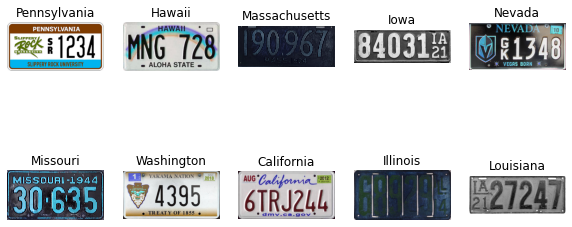

In [7]:
random.seed(2)
sample = random.sample(list(train.index), 10)

fig, ax = plt.subplots(2, 5, figsize=(10, 5))
ax = ax.flatten()

for i, idx in enumerate(sample):
    path = os.path.join('dataset', train.loc[idx, 'Label'], train.loc[idx, 'Image'])
    img = cv2.imread(path)
    ax[i].imshow(img)
    ax[i].set_title(train.loc[idx, 'Label'])
    ax[i].axis('off')
plt.show()

### II.(b) Preparing the training, validation, and test datasets 

In [6]:
def split_data(data, parts):
    # Split the data into the specified number of parts
    splits = np.array_split(data, parts)

    images = []
    labels = []

    # Loop through the splits
    for split in splits:
        # Parse the images in this split
        split_images, split_labels = parse_images(split)

        # Append the parsed images and labels to the lists
        images.append(split_images)
        labels.append(split_labels)

    # Concatenate the splits to get the final datasets
    images = np.concatenate(images)
    labels = np.concatenate(labels)

    return images, labels

def parse_images(data):
    images = []
    labels = []

    # Loop through the CSV entries and load each image
    for index, row in data.iterrows():
        img_path = 'dataset' + '/' + row['Label'] + '/' + row['Image']
        img = cv2.imread(img_path)

        # Resize the image to 500x1000 (looking at img.shape, this is around the average image size)
        img = cv2.resize(img, (1000, 500))
        images.append(img)
        labels.append(row['Label'])
    
    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Split the data into eighths and parse the images
train_X, train_Y = split_data(train, 8)
test_X, test_Y = split_data(test, 8)

#np.save('train_X.npy', train_X)
#np.save('train_Y.npy', train_Y)
#np.save('test_X.npy', test_X)
#np.save('test_Y.npy', test_Y)

In [9]:
#train_X = np.load('train_X.npy')
#train_Y = np.load('train_Y.npy')
#test_X = np.load('test_X.npy')
#test_Y = np.load('test_Y.npy')

print("Shape of train X before validation set: ", np.shape(train_X))
print("Shape of train Y before validation set: ", np.shape(train_Y))

#Use 20% of training data for validation
ind_valid = np.random.choice(3988, 800, replace=False)
ind_train = np.array(list(set(range(3988)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(train_X, valid_X) = train_X[ind_train], train_X[ind_valid] 
(train_Y, valid_Y) = train_Y[ind_train], train_Y[ind_valid]

print("Shape of final train X: ", train_X.shape)
print("Shape of final train y: ", train_Y.shape)

print("Shape of final validation X: ", valid_X.shape)
print("Shape of final valid y: ", valid_Y.shape)

print("Shape of test X: ", np.shape(test_X))
print("Shape of test Y: ", np.shape(test_Y))


Shape of train X before validation set:  (3988, 500, 1000, 3)
Shape of train Y before validation set:  (3988,)
Shape of final train X:  (3188, 500, 1000, 3)
Shape of final train y:  (3188,)
Shape of final validation X:  (800, 500, 1000, 3)
Shape of final valid y:  (800,)
Shape of test X:  (443, 500, 1000, 3)
Shape of test Y:  (443,)


### III.(a) Training Model 1 ()

### III.(b) Training Model 2 ()

### (iii)(c) Training Model 3 ()

### (iv) Model Comparison and Visualization